In [1]:
# import os
# os.chdir('/content/drive/MyDrive/Colab Notebooks/Uvelka/AnomalyDetection')

# Stage 1
Сегментация данных

In [2]:
import pandas as pd
import numpy as np

In [3]:
DATAPAH = '/content/drive/MyDrive/Colab Notebooks/Uvelka/Data/'

In [4]:
raw_data = pd.read_csv(DATAPAH + 'sensor_data.csv', parse_dates=['timestamp'])

<Axes: >

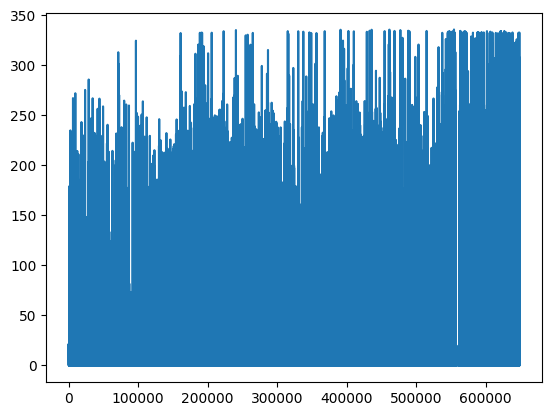

In [5]:
raw_data.amperage.plot()

In [6]:
raw_data[(raw_data.device == 'Токовый ремни  Афл3.1') & (raw_data.timestamp > "2024-12-13 00:00:00") & (raw_data.timestamp < "2024-12-14 00:00:00")]

,timestamp,device,amperage
527148,2024-12-13 00:02:18,Токовый ремни Афл3.1,110.117294
527237,2024-12-13 00:04:13,Токовый ремни Афл3.1,20.558908
527290,2024-12-13 00:05:12,Токовый ремни Афл3.1,21.671530
527408,2024-12-13 00:07:29,Токовый ремни Афл3.1,20.135036
527434,2024-12-13 00:08:00,Токовый ремни Афл3.1,4.926829
...,...,...,...
599585,2024-12-13 23:40:58,Токовый ремни Афл3.1,19.905626
600132,2024-12-13 23:51:48,Токовый ремни Афл3.1,15.651458
600343,2024-12-13 23:55:48,Токовый ремни Афл3.1,1.777001
600356,2024-12-13 23:56:03,Токовый ремни Афл3.1,2.650076


In [7]:
df = raw_data[(raw_data.device == 'Токовый ремни  Афл3.1') & (raw_data.timestamp > "2024-12-12 00:00:00") & (raw_data.timestamp < "2024-12-14 00:00:00")].copy()

In [8]:
df

,timestamp,device,amperage
453649,2024-12-12 00:06:14,Токовый ремни Афл3.1,20.135036
453662,2024-12-12 00:06:30,Токовый ремни Афл3.1,2.604186
453911,2024-12-12 00:11:19,Токовый ремни Афл3.1,0.005457
453936,2024-12-12 00:11:53,Токовый ремни Афл3.1,0.006135
454014,2024-12-12 00:13:26,Токовый ремни Афл3.1,0.009955
...,...,...,...
599585,2024-12-13 23:40:58,Токовый ремни Афл3.1,19.905626
600132,2024-12-13 23:51:48,Токовый ремни Афл3.1,15.651458
600343,2024-12-13 23:55:48,Токовый ремни Афл3.1,1.777001
600356,2024-12-13 23:56:03,Токовый ремни Афл3.1,2.650076


## Использование модели

In [9]:
import numpy as np
import pandas as pd
from sklearn.cluster import MeanShift
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize

from sklearn.metrics import log_loss

class TSTrendDetection():
    def __init__(self, bandwidth = 1.0):
        self.bandwidth = bandwidth
        self.mean_shift = MeanShift(bandwidth = self.bandwidth)
        self.scaler = StandardScaler()

    def fit_mean_shift(self, X):
        """
        Mean Shift model fitting.

        Parameters
        ----------
        X: np.ndarray (shape = (samples_count, 2)) :
            first samples timedelta from first sample
            second samples values
        or
        X: pd.DataFrame:
            has column timedelta from first sample
            has column value

        Returns
        -------
        X: np.ndarray (shape = (samples_count, 2)) :
            first samples time
            second samples values
        labels: np.ndarray:
            np.ndarray (shape = (samples_count,))
        clustered_ts_value: list:
            list of np.ndarray of clustered values
        clustered_ts_time: list:
            list of np.ndarray of clustered times
        clustered_ts_cofs: list:
            list of slopes of linear regression
        clustered_ts_intercepts: list:
            list of intercepts of linear regression
        """
        X = X.copy()

        if isinstance(X, pd.DataFrame):
            X.time = X.time.dt.total_seconds()
            X = X[['time', 'value']].values
        if not isinstance(X, np.ndarray):
            raise ValueError("X must be np.ndarray or pd.DataFrame.")

        # Scaling ts data
        scaler = self.scaler

        X_scaled = scaler.fit_transform(X)

        # Clustering ts data
        self.mean_shift.fit(X_scaled)
        labels = self.mean_shift.labels_

        # Linear regressions for clustered data
        clusters = np.unique(labels)

        clustered_ts_values = dict()
        clustered_ts_times = dict()
        clustered_ts_cofs = dict()
        clustered_ts_intercepts = dict()

        for cluster in clusters:
            clustered_series = X[np.where(labels == cluster)]

            times, values, cof, intercept = self._fit_linear_regression(
                clustered_series)

            clustered_ts_values[cluster] = values
            clustered_ts_times[cluster]= times
            clustered_ts_cofs[cluster] = cof[0]
            clustered_ts_intercepts[cluster] = intercept

        return (X, labels, clustered_ts_times, clustered_ts_values,
                clustered_ts_cofs, clustered_ts_intercepts)

    def _fit_linear_regression(self, clustered_series):
        """fit_linear_regression
        Parameters
        ----------
        clustered_series: np.ndarray (shape = (samples of cluster, 2)) :
            first samples time
            second samples values

        Returns
        -------
        X: np.ndarray (shape = (samples_count, 2)) :
            first samples time
            second samples values
        clustered_ts_value: np.ndarray:
            np.ndarray of clustered values
        clustered_ts_time: np.ndarray:
            np.ndarray of clustered times
        clustered_ts_cofs: float:
            slope of a linear regression
        clustered_ts_intercepts: float:
            intercept of a linear regression
        """
        model = LinearRegression()
        model.fit(clustered_series[:, 0].reshape(-1, 1),
                  clustered_series[:, 1].reshape(-1, 1)
                  )

        clustered_ts_value = model.predict(
            clustered_series[:, 0].reshape(-1, 1)
            )
        clustered_ts_time = clustered_series[:, 0]

        # a - slope of a linear regression
        clustered_ts_cofs = model.coef_[0]

        # b - intercept of a linear regression
        clustered_ts_intercepts = model.intercept_

        return (clustered_ts_time, clustered_ts_value,
                clustered_ts_cofs, clustered_ts_intercepts)

    def predict(self, context, model_input, params=None):
        """
        Prediction method for the custom model.

        Parameters:
        -----------
        context : Any
            Ignored in this example. It's a placeholder for additional data or utility methods.

        model_input : tuple
            The input DataFrame or ndarray classified as normal or has anomaly slope.
            and alpha threshold.

        params : dict, optional
            Additional prediction parameters. Ignored.

        Returns:
        --------
        bool
            Has anomaly TS or not.
        """
        return self._predict_internal(model_input[0], model_input[1])

    def _predict_internal(self, X, alpha):
        """
        Prediction using slopes of linear regressions.
        if true then anomaly detected in time series
        """
        _, _, _, _, clustered_ts_cofs, _ = self.fit_mean_shift(X)
        return (np.array(list(clustered_ts_cofs.values())) > alpha).astype(int)

    def downsample(self, X, smoothing_window = None, skip_window = None):
        """
        Method for time series downsampling.

        Parameters:
        -----------
        X : pd.DataFrame
            first column timedelta
            second column float values
        Returns:
        --------
        pd.DataFrame
            downsampled X.
        """
        if not isinstance(X, pd.DataFrame):
            raise ValueError("Time series must be a pd.Series.")
        X = X.copy()
        if smoothing_window != None:
            X.value = X.value.rolling(window=smoothing_window,
                                                    min_periods=1).median()

        if (skip_window != None):
            X.index = X.time
            X = X.value.resample(skip_window).median().fillna(0)
            X = pd.DataFrame({'time': X.index, 'value': X.values})
        return X

    def _binary_cross_entropy(self, threshold, slopes, labels):
        """
        binary cross entropy
        ----------
        threshold: float:
            finding best threshold, by optimizing bce
        slopes: list, array:
            list of slopes, used as thresholds
        labels: np.ndarray (shape = (samples of cluster, 2)) :
            labeled anomalies: 1 if anomaly, 0 otherwise
        Returns
        -------
        best_threshold: float:
            threshold corresponding to highest f1 score
        """
        predictions = (slopes > threshold).astype(int)
        epsilon = 1e-15
        predictions = np.clip(predictions, epsilon, 1 - epsilon)*10000
        return log_loss(labels, predictions)

    def evaluate_thresholds(self, slopes, labels):
        """
        A method for finding best threshold using binary cross entropy
        ----------
        slopes: list, array:
            list of slopes of linear regressions,
        labels: np.ndarray (shape = (samples of cluster, 2)) :
            labeled anomalies: 1 if anomaly, 0 otherwise
        Returns
        -------
        best_threshold: float:
            threshold corresponding to best cross entropy result
        """
        if len(slopes) < 2:
            return slopes[0]
        if (labels == 1).all():
            return slopes.min()
        if (labels == 0).all():
            return slopes.max()

        initial_threshold = np.mean(slopes)

        # binary cross entropy minimization
        result = minimize(self._binary_cross_entropy, np.mean(slopes),
                          args=(slopes, labels),
                          bounds=[(min(slopes), max(slopes) + 3*np.std(slopes))],)
                          #method='nelder-mead')#,
                          #method='Powell')

        if result.success:
            optimal_threshold = result.x[0]
            return optimal_threshold
        raise Exception("Optimization failed")

Инициализация модели

In [10]:
model = TSTrendDetection(bandwidth = 1.0)

In [11]:
df_input = pd.DataFrame()

In [12]:
df_input[['time','value']] = df[['timestamp','amperage']].copy()

Время для downsampling должно быть в формате timedelta

In [13]:
#df_input['time'] = (df_input['time'] - df_input['time'].iloc[0])#.dt.total_seconds()

In [14]:
df_input

,time,value
453649,2024-12-12 00:06:14,20.135036
453662,2024-12-12 00:06:30,2.604186
453911,2024-12-12 00:11:19,0.005457
453936,2024-12-12 00:11:53,0.006135
454014,2024-12-12 00:13:26,0.009955
...,...,...
599585,2024-12-13 23:40:58,19.905626
600132,2024-12-13 23:51:48,15.651458
600343,2024-12-13 23:55:48,1.777001
600356,2024-12-13 23:56:03,2.650076


In [15]:
params = {"bandwidth": 1.0}

In [16]:
# Если есть skip_window, то ВР группируется по этому параметру.
# Пример есть 3 наблюдения за 1 минуту (1 min 12 sec: 5) (1 min 36 sec: 7) (1 min 47 sec: 9)
# Три наблюдения группируется в одно (1 min 0 sec: 7)
df_down_sampled = model.downsample(df_input, smoothing_window = 20*60, skip_window = '60s')

In [17]:
df_down_sampled['timedate'] = df_down_sampled['time']

In [18]:
df_down_sampled

,time,value,timedate
0,2024-12-12 00:06:00,15.752323,2024-12-12 00:06:00
1,2024-12-12 00:07:00,0.000000,2024-12-12 00:07:00
2,2024-12-12 00:08:00,0.000000,2024-12-12 00:08:00
3,2024-12-12 00:09:00,0.000000,2024-12-12 00:09:00
4,2024-12-12 00:10:00,0.000000,2024-12-12 00:10:00
...,...,...,...
2867,2024-12-13 23:53:00,0.000000,2024-12-13 23:53:00
2868,2024-12-13 23:54:00,0.000000,2024-12-13 23:54:00
2869,2024-12-13 23:55:00,2.770901,2024-12-13 23:55:00
2870,2024-12-13 23:56:00,2.770901,2024-12-13 23:56:00


In [19]:
df_down_sampled['time'] = pd.to_timedelta(df_down_sampled.time - df_down_sampled.time.iloc[0], unit='s')

In [20]:
%%time
data, cluster_labels, clustered_times, clustered_values, clustered_cofs, clustered_intercepts = model.fit_mean_shift(df_down_sampled)

CPU times: user 33.4 s, sys: 241 ms, total: 33.6 s
Wall time: 43.7 s


In [140]:
clustered_cofs

{np.int64(0): np.float64(0.0),
 np.int64(1): np.float64(-6.569136531868001e-07),
 np.int64(2): np.float64(1.8593755996637776e-06),
 np.int64(3): np.float64(0.0)}

## Визуализация

In [22]:
import matplotlib.pyplot as plt

In [23]:
def filtered_clusters(data, labels):

    # 5% от общего количества наблюдений
    alpha = 0.05
    threshold_quantity = alpha * len(labels)
    unique_values, counts = np.unique(labels, return_counts=True)
    filtered_numbers = unique_values[counts > threshold_quantity]

    # Отсеиваем те кластеры, у которых среднее ~ 0
    filtered_means = []
    threshold_mean = 0.15
    for cluster in np.unique(labels):
      cluster_mean = np.mean(data[:, 1][np.where(labels == cluster)])
      if cluster_mean > threshold_mean: filtered_means.append(cluster)

    return np.intersect1d(np.array(filtered_means), filtered_numbers)

Отсеиваем редкие кластеры и кластеры близкие к 0.  
Input Точки, метки кластеров.  
Output Метки классов прошедших фильтр  


In [123]:
filtered_clusters_number = filtered_clusters(data, cluster_labels)

In [124]:
filtered_clusters_number

array([2])

In [125]:
def filter_clusters(filtered_data, *args):
    clustered_cofs = dict()
    clustered_intercepts  = dict()
    for key in filtered_data:
        clustered_cofs[key] = args[0][key]
        clustered_intercepts[key] = args[1][key]
    return (clustered_cofs, clustered_intercepts)

По метке из filtered_clusters_number отсеиваем коэфы наклона и смещения (clustered_cofs, clustered_intercepts)  
Input номера фильтрованных кластеров, наклоны, смещения  
Output фильтрованные наклоны, фильтрованные смещения


In [126]:
filtered_cofs, filtered_intercepts = filter_clusters(filtered_clusters_number, clustered_cofs, clustered_intercepts)

In [129]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates

def plot_LR_results(X, labels, clusters, clustered_values, time = None):
    """
    A method for graphical display of
    the results of constructing a linear regression.
    input
        X - np.ndarray (shape = (samples of cluster, 2))
        labels - cluster labels
        clusters - filtered_clusters_number
        clustered_values - LR values
        time - timestamp if available
    """
    plt.figure(figsize=(15, 8))

    if time is None:
        # Если время в секундах
        time = X[:, 0].copy()
    else:
        # Если время в timestamp
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
        plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))

        plt.xticks(rotation=45)
        plt.tight_layout()

    plt.plot(time, X[:, 1], label='Time Series Data', color='blue')

    scatter = plt.scatter(time[np.isin(cluster_labels, clusters)], X[:, 1][np.isin(cluster_labels, clusters)], c=labels[np.isin(cluster_labels, clusters)], s=82, marker='o', cmap="Spectral")

    for cluster in clusters:
        plt.plot(time[labels == cluster], clustered_values[cluster], color='red', linestyle='-.', label='Trend',
                  linewidth=5, markersize=30, alpha = 0.6)

    cbar = plt.colorbar(scatter, label='Метки кластеров')
    cbar.locator = MaxNLocator(integer=True)
    cbar.update_ticks()
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Результаты линейной регрессии')
    plt.grid()
    plt.legend()

    plt.show()


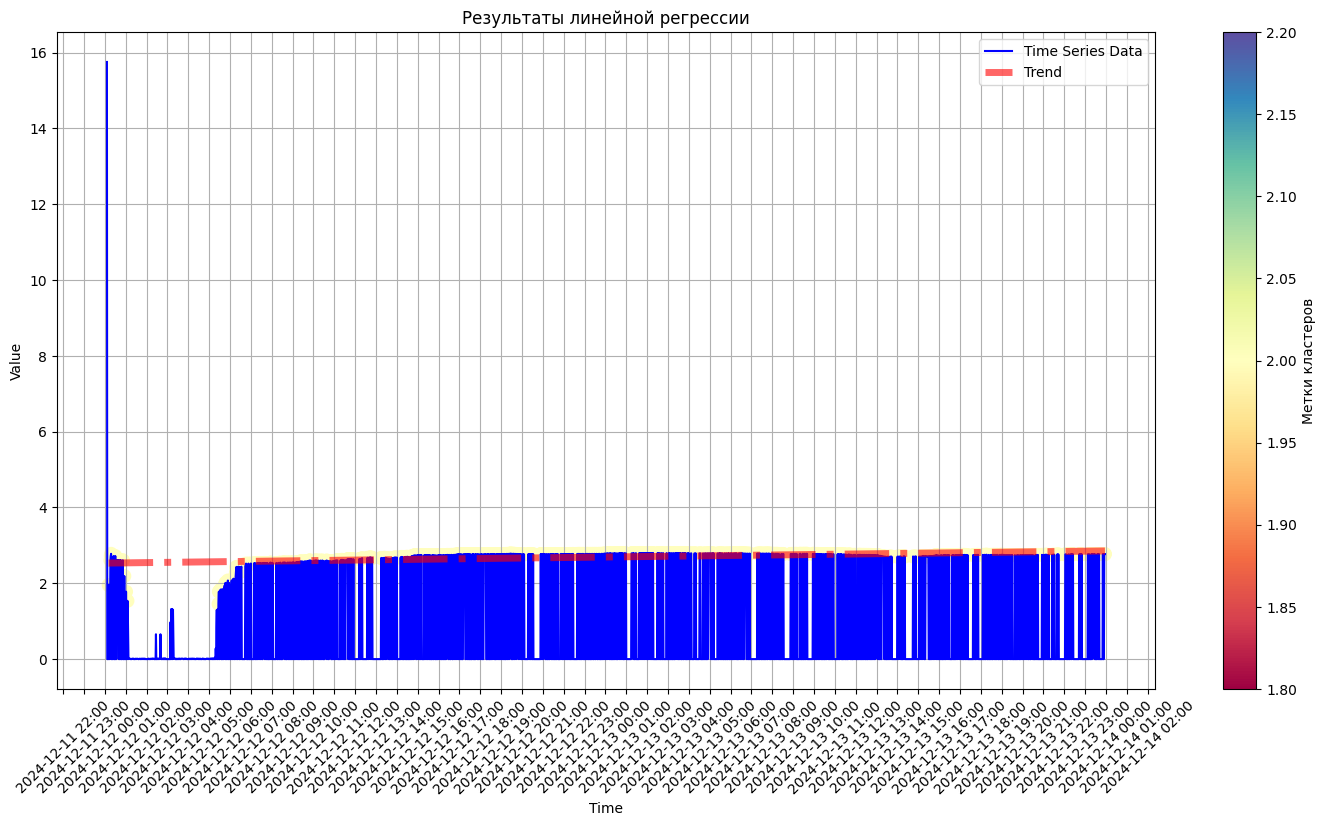

In [130]:
plot_LR_results(data, cluster_labels, filtered_clusters_number, clustered_values, df_down_sampled['timedate'])

# Save artifacts  

сохранять только отфильтрованные alpha - filtered_cofs

In [133]:
filtered_cofs

{np.int64(2): np.float64(1.8593755996637776e-06)}

In [134]:
filtered_intercepts

{np.int64(2): array([2.53317962])}

In [135]:
#Отметили кластер 0 как аномалию, и кластер 1 как норму (метки: 1 - аномалия, 0 - норм)
labels = {
    # 0: 0,
    # 1: 0,
    2: 0,
    # 3: 0,
}

## Stage 2

In [137]:
# Формируем набор тренировочных входных/выходных данных
x_train = []
y_train = []
for cluster in filtered_clusters_number:
    #print(cluster)
    x_train.append(filtered_cofs[cluster])
    y_train.append(labels[cluster])

In [138]:
# Поиск лучшего порога отсечения
x_train = np.array(x_train)
y_train = np.array(y_train)
best_alpha = model.evaluate_thresholds(x_train, y_train)

In [139]:
'''
best_alpha тоже сохраняем, оно потребуется для тестирования модели и в целом инференса
'''
best_alpha

np.float64(1.8593755996637776e-06)

Так как оба не аномальные, то забираем наибольший.  
Если оба были бы аномальные взяли наименьший